In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from net import Net
from dataset import get_caption_dataset
%matplotlib inline

In [8]:
batch_size = 8
image_size = 224
hidden_dim = 128 #512
num_layers = 3 #1

data_root = "./data"
ckpt_path = "./checkpoint_resnet18_3DRNN_1/caption_100.pth"

In [3]:
# to initialize vocab
_, _, TEXT = get_caption_dataset(
    train=True,
    data_root=data_root,
    batch_size=batch_size, image_size=image_size,
    text_field=True)

loader, dataset = get_caption_dataset(
    train=False,
    data_root=data_root,
    batch_size=batch_size, image_size=image_size, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(TEXT, "resnet-18", hidden_dim, num_layers).to(device)

# load pre-trained model
state_dict = torch.load(ckpt_path)
net.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
inputs[0].shape

NameError: name 'inputs' is not defined

In [10]:
net.eval()
cap_repr, pred_repr = list(), list()
with torch.no_grad():
    for inputs in loader:
        image   = inputs[0].to(device)
        caption = inputs[1]
        #print(image)
        preds = net.sample(image)
        print(preds)
        for pred, cap in zip(preds, caption):
            cap_sent, cap_words = dataset.indices_to_string(cap, True)
            pred_sent, pred_words = dataset.indices_to_string(pred, True)
            
            cap_repr.append(cap_sent)
            pred_repr.append(pred_sent)
            
        break # run only first batch

[[   2   14    6   17  123   58   10    9    4   11   20    5   55    8
     3    7    4  656   35  317   31   25   21    7    4   28   22    7
     5    4   28   16    5   11   24    8    3    8    3    5   37    8
     3    5   36    8    3    3    5    8]
 [   2   14    6   12    4   11   20    5   24    7   10   21    9   11
    71  138    7    5   10   59    5   37    8    3   13   18   17   41
    30    8    3    8    3    4    3   30    3    5   36   32   51   10
     8    3    3    3   51   10    9    4]
 [   2   14   17    4   26    6    9    4   11   39    5    4   28   83
    10   18    8    3   13   27    5    3   51   30    8    3    8    3
     5   51   16    8    3   51   49   16    9   10   48    8    3  230
    13    6   17   10    9   11   21    5]
 [   2   14    6   12    4   10   29    9    4   11   55    5   55    7
     9    4   28   22    8    3    5    4   11    5   10   29    8    3
     3    4   49   16  160    5   10    8    3    8    3   37   51   11
     9 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


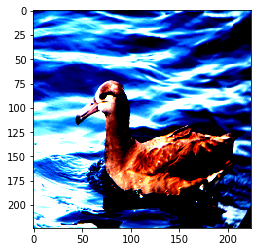

In [12]:
im = image[2]
im = im.cpu().numpy()
im = np.transpose(im,(1,2,0))
plt.imshow(im)
plt.show()

In [6]:
def inverse_transform(image):
    transform = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
    image = image.clone()
    image = transform(image).mul(255).clamp_(0, 255)
    
    return image.byte().permute(1, 2, 0).cpu().numpy()

def pretty_print(string, width=100):
    new_string = ""
    for i in range(0, len(string), width):
        new_string += string[i:i+width]
        
        if i+width < len(string):
            new_string += "\n"
    return new_string

torch.Size([1, 3, 427, 640])
[[  2  13   6  12   4  10  27   5   4  15  10  22   8   3   8   3   8   3
   35  29   8   3   5  21   8   3  51  33   8   3  51   4 845  79   8   3
    7   9  11  20   5  76   5  20   8  13 431  17  41   5]]


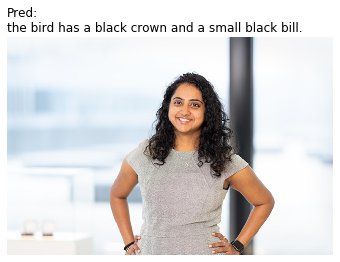

In [12]:
#own_preds = []
my_img_old = plt.imread('./assets/Abi1.JPG')
my_img = np.transpose(my_img_old,(2,0,1))
input_im = torch.Tensor(my_img.reshape(1, my_img.shape[0], my_img.shape[1], my_img.shape[2])).cuda()
#torch.transpose(input_im, 0,3,1,2)
print(input_im.shape)
preds = net.sample(input_im)
print(preds)
for pred in preds:
    pred_sent, pred_words = dataset.indices_to_string(pred, True)
    #own_preds.append(pred_sent)
    pred = pretty_print(pred_sent)
    
    sentence = "Pred:\n{}".format(pred)
    
    fig = plt.figure()
    plt.title(sentence, loc="left")
    plt.imshow(my_img_old)
    plt.axis("off")

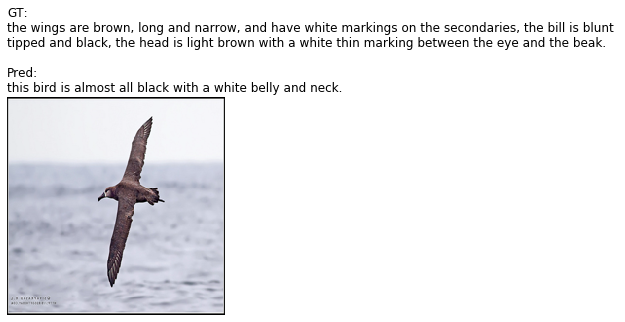

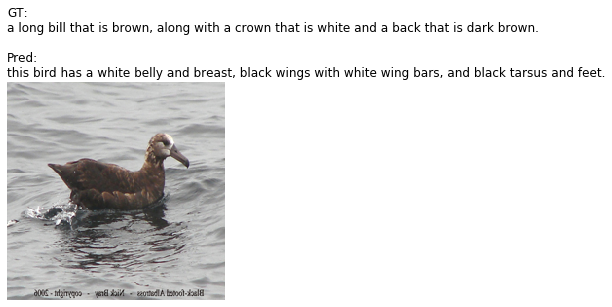

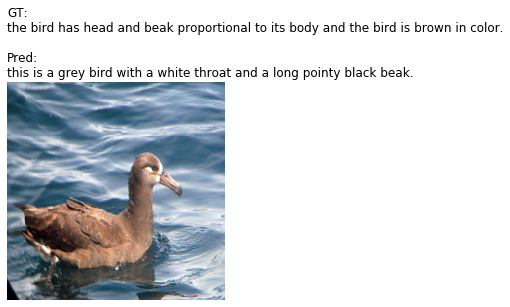

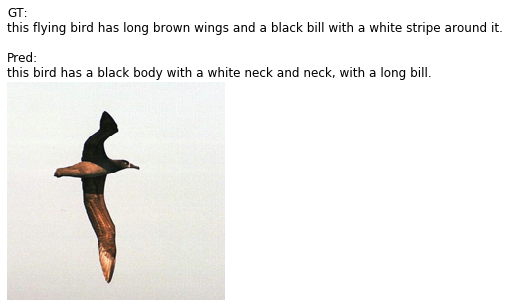

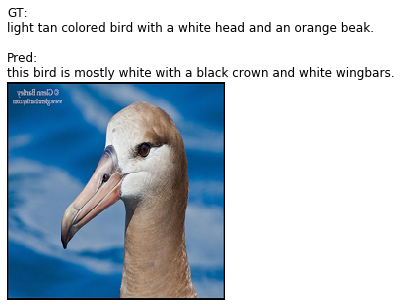

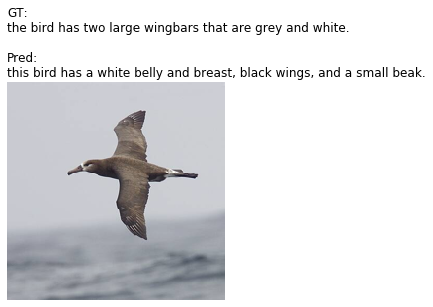

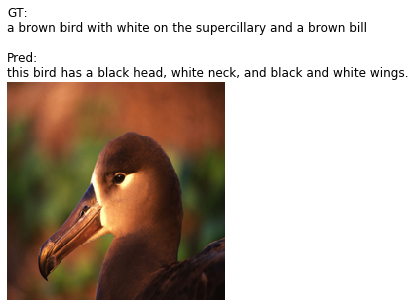

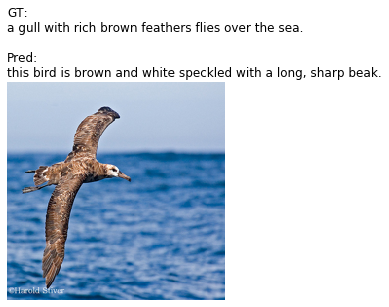

In [11]:
# visualize first batch
for i, (im, cap, pred) in enumerate(zip(image, cap_repr, pred_repr)):
    im = inverse_transform(im)
    
    cap = pretty_print(cap)
    pred = pretty_print(pred)
    
    sentence = "GT:\n{}\n\nPred:\n{}".format(cap, pred)
    
    fig = plt.figure()
    plt.title(sentence, loc="left")
    plt.imshow(im)
    plt.axis("off")